In [6]:
# 决策树
import numpy as np
import pandas as pd
import math
from math import log

In [7]:
# 创建数据
def create_data():
    datasets = [['青年', '否', '否', '一般', '否'],
               ['青年', '否', '否', '好', '否'],
               ['青年', '是', '否', '好', '是'],
               ['青年', '是', '是', '一般', '是'],
               ['青年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '好', '否'],
               ['中年', '是', '是', '好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '好', '是'],
               ['老年', '是', '否', '好', '是'],
               ['老年', '是', '否', '非常好', '是'],
               ['老年', '否', '否', '一般', '否'],
               ]
    labels = [u'年龄', u'有工作', u'有自己的房子', u'信贷情况', u'类别']
    return datasets, labels

In [8]:
datasets, labels = create_data()

In [9]:
train_data = pd.DataFrame(datasets, columns=labels)

In [10]:
train_data

,年龄,有工作,有自己的房子,信贷情况,类别
0,青年,否,否,一般,否
1,青年,否,否,好,否
2,青年,是,否,好,是
3,青年,是,是,一般,是
4,青年,否,否,一般,否
5,中年,否,否,一般,否
6,中年,否,否,好,否
7,中年,是,是,好,是
8,中年,否,是,非常好,是
9,中年,否,是,非常好,是


In [11]:
# 熵
def calc_ent(datasets):
    data_length = len(datasets)
    label_count = {}
    for i in range(data_length):
        label = datasets[i][-1]
        if label not in label_count:
            label_count[label] = 0
        label_count[label] += 1
    ent = -sum([(p / data_length) * log(p / data_length, 2)
                for p in label_count.values()])
    return ent

In [12]:
# 条件熵
def cond_ent(datasets, axis=0):
    data_length = len(datasets)
    feature_sets = {}
    for i in range(data_length):
        feature = datasets[i][axis]
        if feature not in feature_sets:
            feature_sets[feature] = []
        feature_sets[feature].append(datasets[i])
    cont_ent = sum([(len(p) / data_length) * calc_ent(p)
                   for p in feature_sets.values()])
    return cond_ent

In [13]:
calc_ent(datasets)

0.9709505944546686

In [14]:
# 信息增益
def info_gain(ent, cond_ent):
    return ent - cond_ent

In [15]:
def info_gain_train(datasets):
    count = len(datasets[0]) - 1
    ent = calc_ent(datasets)
    best_feature = []
    for c in range(count):
        c_info_gain = info_gain(ent, cond_ent(datasets, axis=c))
        best_feature.append((c, c_info_gain))
        print('特征({}) 的信息增益为： {:.3f}'.format(labels[c], c_info_gain))
    best_ = max(best_feature, key=lambda x: x[-1])
    return '特征({})的信息增益最大，选择为根节点特征'.format(labels[best_[0]])

In [30]:
info_gain_train(np.array(datasets))

TypeError: unsupported operand type(s) for -: 'float' and 'function'

In [28]:
# ID3算法生成决策树
class Node:
    def __init__(self, root=True, label=None, feature_name=None, feature=None):
        self.root = root
        self.label = label
        self.feature_name = feature_name
        self.feature = feature
        self.tree = {}
        self.result = {
            'label:': self.label,
            'feature': self.feature,
            'tree': self.tree
        }
    def __repr__(self):
        return '{}'.format(self.result)
    def add_node(self, val, node):
        self.tree[val] = node
    def predict(self, features):
        if self.root is True:
            return self.label
        return self.tree[features[self.feature]].predict(features)

class DTree:
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self._tree = {}
    # 熵
    @staticmethod
    def calc_ent(datasets):
        data_length = len(datasets)
        label_count = {}
        for i in range(data_length):
            label = datasets[i][-1]
            if label not in label_count:
                label_count[label] = 0
            label_count[label] += 1
        ent = -sum([(p / data_length) * log(p / data_length, 2)
                   for p in label_count.values()])
        return ent
    # 经验条件熵
    def cond_ent(self, datasets, axis=0):
        data_length = len(datasets)
        feature_sets = {}
        for i in range(data_length):
            feature = datasets[i][axis]
            if feature not in feature_sets:
                feature_sets[feature] = []
            feature_sets[feature].append(datasets[i])
        cond_ent = sum([(len(p) / data_length) * self.calc_ent(p)
                       for p in feature_sets.values()])
        return cond_ent
    # 信息增益
    @staticmethod
    def info_gain(ent, cond_ent):
        return ent - cond_ent
    def info_gain_train(self, datasets):
        count = len(datasets[0]) - 1
        ent = self.calc_ent(datasets)
        best_feature = []
        for c in range(count):
            c_info_gain = self.info_gain(ent, self.cond_ent(datasets, axis=c))
            best_feature.append((c, c_info_gain))
        # 比较大小
        best_ = max(best_feature, key=lambda x: x[-1])
        return best_
    def train(self, train_data):  # 输入为数据集输出为决策树
        _, y_train, features = train_data.iloc[:, :
                                              -1], train_data.iloc[:,
                                                                  -1], train_data.columns[:
                                                                                         -1]
        if len(y_train.value_counts()) == 1: # 若数据集均为同一类，则树为单节点树
            return Node(root=True, label=y_train.iloc[0])
        if len(features) == 0: #  若特征集为空，则树为单节点树
            return Node(
                root=True,
                label=y_train.value_counts().sort_values(
                    ascending=Flase).index[0])
        max_feature, max_info_gain = self.info_gain_train(np.array(train_data))
        max_feature_name = feature[max_feature]  # 计算最大信息增益
        # 如果信息增益小于阈值，则树为单节点树
        if max_info_gain < self.epsilon:
            return Node(
                root=True,
                label=y_train.value_counts().sort_values(
                    ascending=Flase).index[0])
        # 构建子集
        node_tree = Node(
            root=Flase, feature_name=max_feature_name, feature=max_feature)
        feature_list = train_data[max_feature_name].value_counts().index
        for f in feature_list:
            sub_train_df = train_data.iloc[train_data[max_feature_name] ==
                                          f].drop([max_feature_name], axis=1)
            sub_tree = self.train(sub_train_df)
            node_tree.add_node(f, sub_tree) # 递归生成树
        return node_tree
    def fit(self, train_data):
        self._tree = self.train(train_data)
        return self._tree
    def predict(self, X_test):
        return self._tree.predict(X_test)

In [29]:
datasets, labels = create_data()
data_df = pd.DataFrame(datasets, columns=labels)
dt = DTree()
tree = dt.fit(data_df)

NameError: name 'feature' is not defined

In [25]:
tre
dt.predict(['老年', '否', '否', '一般'])

NameError: name 'tree' is not defined

In [31]:
# sklearn构造
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from collections import Counter

In [34]:
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = [
        'sepal length', 'speal width', 'petal length', 'petal width', 'label'
    ]
    data = np.array(df.iloc[:100, [0, 1, -1]])
    return data[:, :2], data[:, -1],iris.feature_names[0:2]

X, y, feature_name = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn import tree
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train,)
clf.score(X_test, y_test)

1.0

[Text(0.4090909090909091, 0.9, 'X[1] <= 2.95\ngini = 0.5\nsamples = 70\nvalue = [36, 34]'),
 Text(0.18181818181818182, 0.7, 'X[0] <= 4.7\ngini = 0.071\nsamples = 27\nvalue = [1, 26]'),
 Text(0.09090909090909091, 0.5, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.2727272727272727, 0.5, 'gini = 0.0\nsamples = 26\nvalue = [0, 26]'),
 Text(0.6363636363636364, 0.7, 'X[0] <= 5.55\ngini = 0.303\nsamples = 43\nvalue = [35, 8]'),
 Text(0.45454545454545453, 0.5, 'X[0] <= 5.3\ngini = 0.057\nsamples = 34\nvalue = [33, 1]'),
 Text(0.36363636363636365, 0.3, 'gini = 0.0\nsamples = 28\nvalue = [28, 0]'),
 Text(0.5454545454545454, 0.3, 'X[1] <= 3.2\ngini = 0.278\nsamples = 6\nvalue = [5, 1]'),
 Text(0.45454545454545453, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.6363636363636364, 0.1, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(0.8181818181818182, 0.5, 'X[1] <= 3.65\ngini = 0.346\nsamples = 9\nvalue = [2, 7]'),
 Text(0.7272727272727273, 0.3, 'gini = 0.0\nsamples = 7\nvalue = [

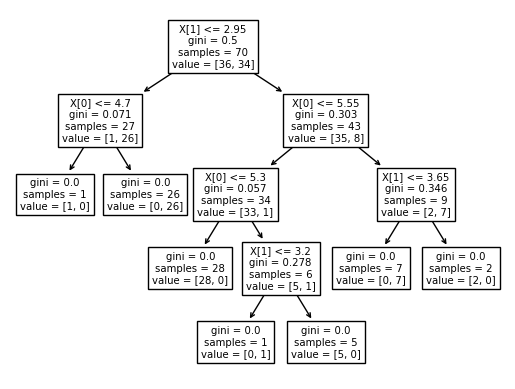

In [38]:
tree.plot_tree(clf) 

In [39]:
# 导出树
tree_pic = export_graphviz(clf, out_file='mytree.pdf')
with open('mytree.pdf') as f:
    dot_graph = f.read()

In [41]:
graphviz.Source(dot_graph)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [42]:
# 决策树回归
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

In [43]:
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

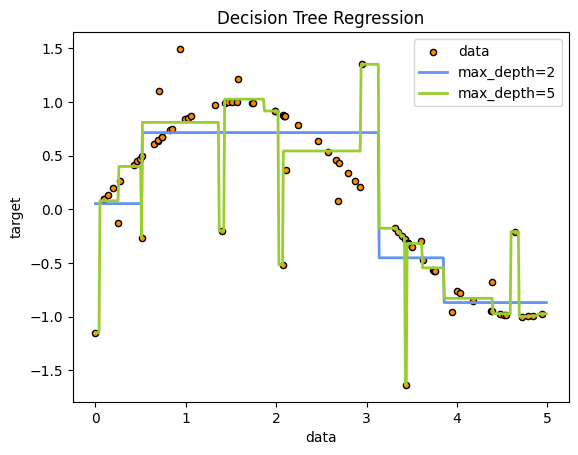

In [45]:
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)
# predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)
plt.figure()
plt.scatter(X, y, s=20, edgecolor='black', c='darkorange', label='data')
plt.plot(X_test, y_1, color='cornflowerblue', label='max_depth=2', linewidth=2)
plt.plot(X_test, y_2, color='yellowgreen', label='max_depth=5', linewidth=2)
plt.xlabel('data')
plt.ylabel('target')
plt.title('Decision Tree Regression')
plt.legend()
plt.show()

In [49]:
# 决策树参数
DecisionTreeClassifier(criterion="gini",
                 splitter="best",
                 max_depth=None,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 min_weight_fraction_leaf=0.,
                 max_features=None,
                 random_state=None,
                 max_leaf_nodes=None,
                 min_impurity_decrease=0.,
                 min_impurity_split=None,
                 class_weight=None,
                 presort=False)

TypeError: DecisionTreeClassifier.__init__() got an unexpected keyword argument 'min_impurity_split'

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

In [53]:
X = datasets.load_iris()
data = X.data
target = X.target
name = X.target_names
x, y = datasets.load_iris(return_X_y=True)
print(x.shape, y.shape)

(150, 4) (150,)


In [54]:
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=100)

In [55]:
param = {
    'criterion': ['gini'],
    'max_depth': [30, 50, 60, 100],
    'min_samples_leaf': [2, 3, 5, 10],
    'min_impurity_decrease': [0.1, 0.2, 0.5]
}
grid = GridSearchCV(DecisionTreeClassifier(), param_grid=param, cv=6)
grid.fit(x_train, y_train)
print('最优分类器:', grid.best_params_, '最优分数:', grid.best_score_)

最优分类器: {'criterion': 'gini', 'max_depth': 30, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 10} 最优分数: 0.9416666666666665
